### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2\models
c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2


In [2]:
import importlib
import torch
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_32hidden_3kernel_48_layers_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
class MultiFixedRotation:
    '''
    Class that implements random rotations of the dataset at fixed angles
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x, seed):
        random.seed(seed)
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

def augmentation(train_dataset, seed=42, angles=[90,180,270], p_hflip=0.5, full=True):
    '''
    Function for implementing data augmentation of inputs (DEM, X- and Y-Slope,
    Water Depth, and Discharge).

    Input: train_dataset = torch tensor, dataset with input variables
           seed = int, number for keeping the same random choice for trasforming both inputs and outputs in the same way, 
                  default = 42 
           angles = list of angle degrees for random rotation of the dataset, 
                    default = 90°, 180°, 270°
           p_hflip = float, probability of horizontal flipping
                     default = 0.5 
           
    Output: transformed_dataset = new dataset with augmented data,
                                  if full = True returns the original and trasformed dataset concatenated together
                                  if full = False returns only the trasformed dataset 
    '''
    
    # transformation pipeline with horizontal flip
    transformation_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(p=p_hflip)])
    
    # rotation with MultiFixedRotation class
    fixed_rotation = MultiFixedRotation(angles)
    
    # initialize lists needed for looping
    inputs = []
    outputs = []

    transformed_inputs = []
    transformed_outputs = []

    for idx in range(len(train_dataset)):
        inputs.append(train_dataset[idx][0])
        outputs.append(train_dataset[idx][1]) 
        
        # apply augmentation (flipping + rotation)
        transformed_inputs.append(fixed_rotation(transformation_pipeline(train_dataset[idx][0]), seed))
        transformed_outputs.append(fixed_rotation(transformation_pipeline(train_dataset[idx][1]), seed))   

    # transformed_dataset = multi_fixed_rotation(transformation_pipeline(train_dataset))

    # stack lists
    inputs_stack = torch.stack(inputs)
    outputs_stack = torch.stack(outputs)

    transformed_inputs = [torch.tensor(i) for i in transformed_inputs]
    transformed_outputs = [torch.tensor(i) for i in transformed_outputs]

    transformed_inputs = torch.stack(transformed_inputs)
    transformed_outputs = torch.stack(transformed_outputs)

    # concatenate tensors
    all_inputs = torch.cat([inputs_stack, transformed_inputs])
    all_outputs = torch.cat([outputs_stack, transformed_outputs])

    transformed_dataset = torch.utils.data.TensorDataset(all_inputs, all_outputs)
    
    if full==True:
        print(f'The samples in the dataset before augmentation were {len(train_dataset)}\n\
The samples in the dataset after augmentation are {len(transformed_dataset)}')
    
    if full==False:
        transformed_dataset = torch.utils.data.TensorDataset(transformed_inputs, transformed_outputs)
        warning_msg = (
f'\nBe careful, you are not including the transformed dataset into the original one!\n\
The samples in the dataset before augmentation were {len(train_dataset)}\n\
The samples in the dataset after augmentation are {len(transformed_dataset)}\n\
You are now using only the transformed dataset.'
)
        warnings.warn(warning_msg, RuntimeWarning)
    return transformed_dataset

In [8]:
# transformed_dataset = augmentation(train_dataset, seed=42, p_hflip=0.5, full=True)
transformed_dataset = train_dataset

In [9]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_wd, scaler_q, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_wd, scaler_q, train_val)

In [11]:
# Model
# model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], 
#                           hidden_dim = 8, kernel_size = (3, 3), num_layers = 8, batch_first=True, bias=True, return_all_layers = False).to(device)

model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
                 num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [12]:
model

ConvLSTM(
  (conv2): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(36, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [13]:
# Set training parameters
learning_rate = 0.005
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 50 #1_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [14]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    if count > 300:
        print(f"Loss Stagnated for 300 epochs, early stopping initiated")
        break

In [15]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

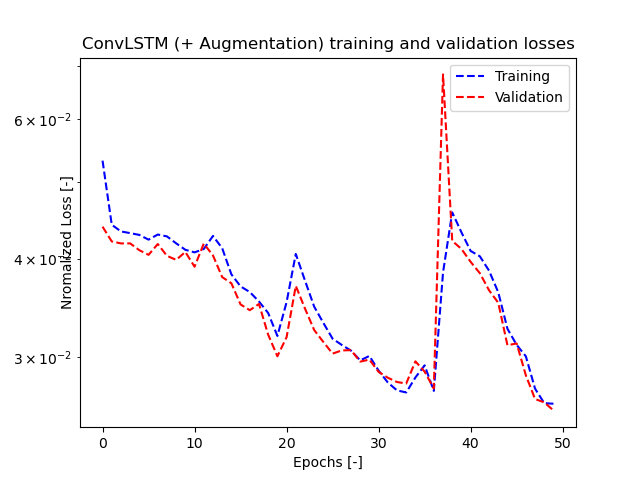

In [16]:
plot_losses(train_losses, val_losses, 'ConvLSTM (+ Augmentation) ')

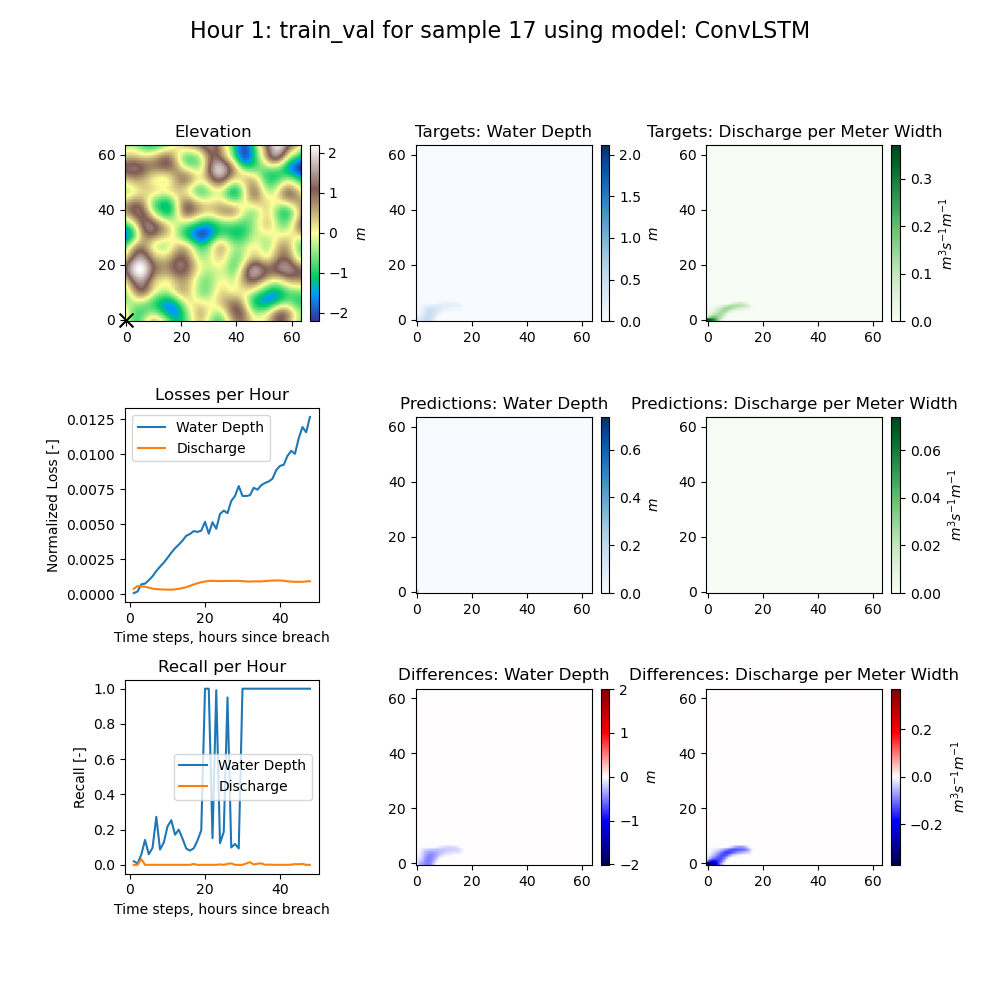

In [23]:
plot_animation(17, normalized_train_dataset, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)

In [ ]:
normalized_train_dataset[0][1].shape

In [ ]:
plot_sorted(normalized_train_dataset, train_val, scaler_x, scaler_wd, scaler_q, model, device)